# Contents
- [Import Libraries](#import)
- [Preliminary Analysis](#anal)
    - [Train Data](#train)
    - [Spray Data](#spray)
- [Feature Engineering](#feat)
- [Weather Data Mapping](#weather)
- [EDA on Temporal Features](#EDA)
- [Export CSVs](#csv)

# Import Libraries<a id=import></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import math
import haversine as hv

from sklearn.linear_model import LinearRegression

from datetime import timedelta

In [2]:
train = pd.read_csv('data/train.csv')
weather = pd.read_csv('data/weather.csv')
spray = pd.read_csv('data/spray.csv')
test = pd.read_csv('data/test.csv')

---
# Preliminary Analysis<a id=anal></a>
### &nbsp;&nbsp;Train data<a id = train></a>
First, we check the features available to us in our train data.

In [ ]:
train.columns

Next, we check the dtypes of our train data to check for any irregularities.

In [168]:
train.dtypes

Date                       object
Address                    object
Species                    object
Block                       int64
Street                     object
Trap                       object
AddressNumberAndStreet     object
Latitude                  float64
Longitude                 float64
AddressAccuracy             int64
NumMosquitos                int64
WnvPresent                  int64
dtype: object

It seems that our dtypes for our data is ok.<br/>

Next, we plot a latitude and longitude scatterplot to observe if there any trends available location-wise.

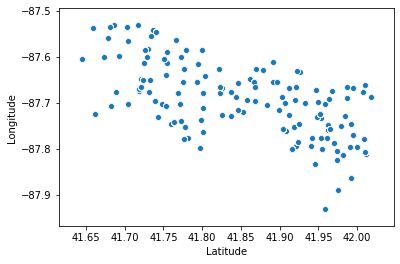

In [165]:
sns.scatterplot(x='Latitude',y='Longitude',data=train)

The trap placements in our dataset are quite well spread-out and not much of a trend is observed.<br/>

Next, we find out which streets have the most number of mosquitoes caught in traps and have the highest occurences of the West Nile virus. 

In [6]:
sum_wnv = train.groupby(by='Street')['NumMosquitos','WnvPresent'].sum().sort_values(by=['WnvPresent','NumMosquitos'],ascending=False)
sum_wnv['NumMosquitos'] = sum_wnv['NumMosquitos'].astype('int')
sum_wnv['WnvPresent'] = sum_wnv['WnvPresent'].astype('int')
# sum_wnv = sum_wnv.reset_index()
sum_wnv.head(8)

,NumMosquitos,WnvPresent
Street,,
W OHARE AIRPORT,15386,66
S DOTY AVE,21668,41
N OAK PARK AVE,3940,24
S STONY ISLAND AVE,10006,17
N MILWAUKEE AVE,1346,14
E 105TH ST,3315,11
S KOSTNER AVE,2014,11
N PITTSBURGH AVE,1311,11


From the table above, it seems that W OHARE AIRPORT, S DOTY AVE and N OAK PARK AVE have the greatest presence of mosquitoes carrying the West Nile virus (WNV). 

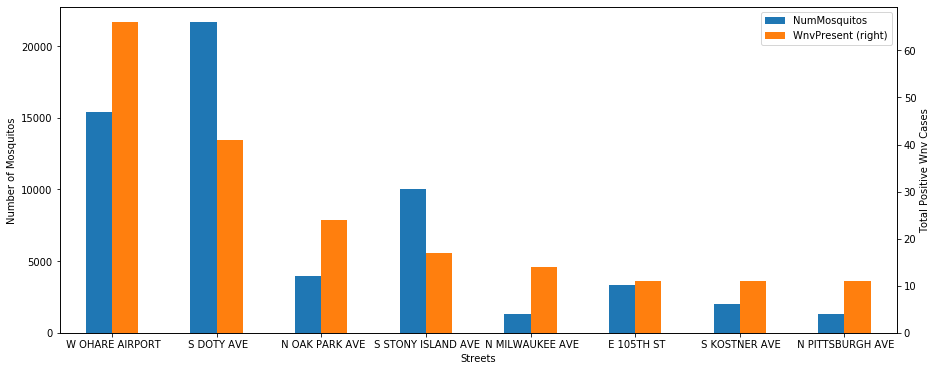

In [23]:
# Plot

ax = sum_wnv.head(8).plot(kind= 'bar',secondary_y='WnvPresent',rot= 0,figsize=(15,6))
ax.set_xlabel("Streets")
ax.set_ylabel("Number of Mosquitos")
ax.right_ax.set_ylabel("Total Positive Wnv Cases")
plt.show()


We observe that the number of mosquitoes does not have a direct correlation to the occurence of WNV carrying mosquitoes from the bar chart above.

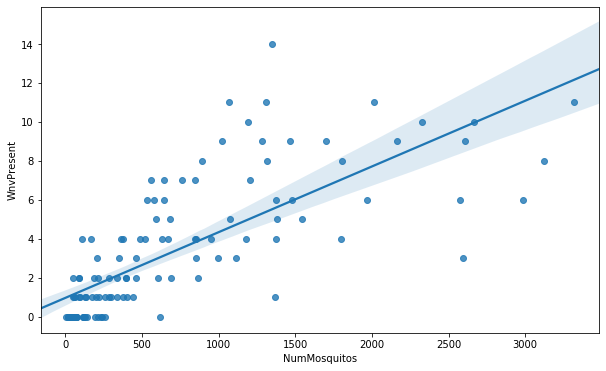

In [40]:
plt.figure(figsize=(10,6))
sns.regplot(x='NumMosquitos',y='WnvPresent',data=sum_wnv[sum_wnv['NumMosquitos']<3500])

More specifically, a correlation exists but it is not a very strong correlation.<br/>
The residuals also seem to be heteroscedactic in their variance.

___
### &nbsp;&nbsp;Spray data<a id = spray></a>
We check the features available to us in our spray data.

In [166]:
spray.columns

Index(['Date', 'Time', 'Latitude', 'Longitude'], dtype='object')

and we plot a scatterplot of latitude and longitudes to observe the spread of spray locations.

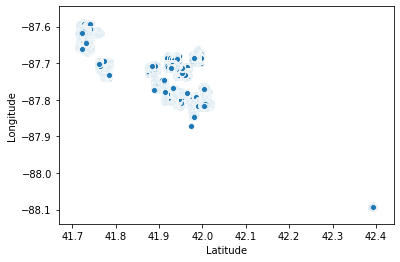

In [167]:
sns.scatterplot(x='Latitude',y='Longitude',data=spray)

The spray location seem to be clustered in a few areas and are not as well spread-out as the trap placements.<br/>
We will have to feature engineer the spray data later on to utilize this information.<br/>

We drop any duplicate spray locations in our spray data.

In [169]:
spray = spray.drop_duplicates(subset=['Latitude', 'Longitude'], keep=False)

---
# Feature Engineering<a id = feat></a>

Here, we will create a feature of the trap distance to the nearest spray point within 3 days of each day.

In [ ]:
# Convert all date features to the date-time format
spray.Date = spray.Date.astype('datetime64[ns]')
train.Date = train.Date.astype('datetime64[ns]')
test.Date = test.Date.astype('datetime64[ns]')

In [171]:
train.Date[1]

Timestamp('2007-05-29 00:00:00')

In [190]:
test.Date.head()

0   2008-06-11
1   2008-06-11
2   2008-06-11
3   2008-06-11
4   2008-06-11
Name: Date, dtype: datetime64[ns]

In [172]:
train.Date.head()

0   2007-05-29
1   2007-05-29
2   2007-05-29
3   2007-05-29
4   2007-05-29
Name: Date, dtype: datetime64[ns]

In [227]:
spray.Date.tail()

14830   2013-09-05
14831   2013-09-05
14832   2013-09-05
14833   2013-09-05
14834   2013-09-05
Name: Date, dtype: datetime64[ns]

We map spray longitude and latitudes to a new feature called 'coords' in our spray data.

In [175]:
spray['coords'] = spray.apply(lambda x: ([x.Latitude, x.Longitude]), axis=1)

and we create a function that will return the nearest distance from a trap to a spray location in a set number of days.<br/>
We set the number of days to be 7 as [this article](https://www.channelnewsasia.com/news/singapore/mosquito-fogging-has--severe-limitation--nea-7777798) states that after pesticide spraying, *'within a week, the larvae will be flying around.'*

In [233]:
def nearest_spray(date, in_coords, n_diff=7):
    
    
    start_date = date
    end_date = date + timedelta(days=n_diff)
    mask = (spray.Date >= start_date) & (spray.Date <= end_date)
    spray_subset = spray[mask]
    
    if not spray_subset.empty:
        dist = [hv.haversine(in_coords,coord) for coord in (spray_subset.coords)]     
        return round(min(dist),2)
    else:
        print('empty subset')
        return np.nan

we create new features that encode nearest spray locations to our trap locations.

In [179]:
%time
train['spray_dist'] = train.apply(lambda x: nearest_spray(x.Date,[x.Latitude, x.Longitude]), axis=1)
test['spray_dist'] = test.apply(lambda x: nearest_spray(x.Date,[x.Latitude, x.Longitude]), axis=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


and we set a feature which informs us if a trap location has been sprayed within 3 km in 7 days.

In [185]:
## spray_status : 1 if less than 7 days and 3 km, else 0
train['spray_status'] = train.apply(lambda x: 1 if (x.spray_dist <= 3) else 0,axis=1)
test['spray_status'] = test.apply(lambda x: 1 if (x.spray_dist <= 3) else 0,axis=1)

In [182]:
train.spray_status.value_counts()

0    10208
1      298
Name: spray_status, dtype: int64

We can see that only 298 sites are covered under the spray conditions.<br/>

Next, we check how many sites in our test data coincide with our spray data.

In [229]:
start_date = test.Date[1]
end_date = start_date + timedelta(days=30)
mask = (start_date <= spray.Date ) & (spray.Date <= end_date)
spray_subset = spray[mask]
display(spray_subset)

,Date,Time,Latitude,Longitude,coords


It seems that there are no sites in our test data that coincide with our spray datapoints even when the date range has been set at 30 days. <br/>
Let us investigate what the issue is.

In [240]:
test['year'] = test.Date.map(lambda x : x.year)
spray['year'] = spray.Date.map(lambda x: x.year)

In [241]:
spray.year.value_counts()

2013    12626
2011     1666
Name: year, dtype: int64

In [242]:
test.year.value_counts()

2010    36557
2008    30498
2012    27115
2014    22123
Name: year, dtype: int64

In [160]:
spray.count()

Date         14292
Time         13708
Latitude     14292
Longitude    14292
coords       14292
dtype: int64

It seems that the years in which our spray data has been collected do not coincide with the years in which our test data has been collected.<br/>
We would not be able to use our spray data as part of our classifier model for the Kaggle prediction.

---
# Weather Data Mapping<a id=weather></a>
Our weather data comes from 2 weather stations.<br/>
In this section, we map weather data to the closest trap locations for the most relevant weather information for the traps.

We import our weather data and drop unusable features.

In [21]:
weather = pd.read_csv('weather_cleaned_stack_back.csv')
weather.drop(columns='Unnamed: 0',inplace=True)

We examine our weather data for any further irregularities.

In [23]:
weather.Date = weather.Date.astype('datetime64[ns]')
weather.head()

,Date,Sunset,DaylightHrs,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Cool,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed,Station
0,2007-05-01,1849,1401,83.0,50.0,67.0,14.0,51.0,56.0,2.0,0.000,29.10,29.82,1.7,27.0,9.2,1
1,2007-05-02,1850,1403,59.0,42.0,51.0,-3.0,42.0,47.0,0.0,0.000,29.38,30.09,13.0,4.0,13.4,1
2,2007-05-03,1851,1405,66.0,46.0,56.0,2.0,40.0,48.0,0.0,0.000,29.39,30.12,11.7,7.0,11.9,1
3,2007-05-04,1852,1408,66.0,49.0,58.0,4.0,41.0,50.0,0.0,0.001,29.31,30.05,10.4,8.0,10.8,1
4,2007-05-05,1853,1410,66.0,53.0,60.0,5.0,38.0,49.0,0.0,0.001,29.40,30.10,11.7,7.0,12.0,1


Our data seems to be usable. We move onward with our weather mapping.

In [244]:
# Set weather date to date-time format
weather.Date = weather.Date.astype('datetime64[ns]')

In [245]:
# Create a 'year' feature for our weather data
weather['year'] = weather.Date.map(lambda x : x.year)

In [248]:
# Check the years present in our weather data
weather.year.value_counts()

2013    368
2011    368
2009    368
2007    368
2014    368
2012    368
2010    368
2008    368
Name: year, dtype: int64

We assign our 2 weather stations to their geographical coordinates

In [1]:
STATIONS = {
    1 : (41.995,-87.933),
    2 : (41.786,-87.752)
}

We create a function that maps the distance of the nearest station to our trap locations

In [8]:
def nearest_station(in_coords):
    
    dist = {k:hv.haversine(in_coords,v) for k,v in STATIONS.items()}
    
    return min(dist, key=dist.get)

We create new features where we have mapped our trap locations to the nearest weather stations.

In [90]:
train['nearest_station'] = train.apply(lambda x: nearest_station([x.Latitude, x.Longitude]), axis=1)
test['nearest_station'] = test.apply(lambda x: nearest_station([x.Latitude, x.Longitude]), axis=1)

We check the counts to ensure that each data point has been mapped to a nearest station.

In [91]:
train.nearest_station.value_counts()

2    7208
1    3298
Name: nearest_station, dtype: int64

In [92]:
train.count()

Date                      10506
Address                   10506
Species                   10506
Block                     10506
Street                    10506
Trap                      10506
AddressNumberAndStreet    10506
Latitude                  10506
Longitude                 10506
AddressAccuracy           10506
NumMosquitos              10506
WnvPresent                10506
nearest_station           10506
date_lag                  10506
dtype: int64

Next we create a feature called date lag which encodes the time delay to which we have mapped our weather data.

In [103]:
train['date_lag'] = train.Date.map(lambda x : x - timedelta(days=7))
test['date_lag'] = test.Date.map(lambda x : x - timedelta(days=7))

In [104]:
train_weather = train.merge(weather,left_on=['date_lag','nearest_station'],right_on=['Date','Station'])
test_weather = test.merge(weather,left_on=['date_lag','nearest_station'],right_on=['Date','Station'])

In [105]:
train.Date.head()

0   2007-05-29
1   2007-05-29
2   2007-05-29
3   2007-05-29
4   2007-05-29
Name: Date, dtype: datetime64[ns]

In [106]:
weather.Date.head()

0   2007-05-01
1   2007-05-02
2   2007-05-03
3   2007-05-04
4   2007-05-05
Name: Date, dtype: datetime64[ns]

In [107]:
train_weather.columns

Index(['Date_x', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent', 'nearest_station', 'date_lag', 'Date_y',
       'Sunset', 'DaylightHrs', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint',
       'WetBulb', 'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel',
       'ResultSpeed', 'ResultDir', 'AvgSpeed', 'Station'],
      dtype='object')

We also create a feature called month to be used in our classifier as nominal data instead of ordinal.

In [108]:
train_weather['month'] = train_weather.Date_x.map(lambda x : x.month)
test_weather['month'] = test_weather.Date_x.map(lambda x : x.month)

In [1]:
cols = ['month','Species','NumMosquitos','Sunset', 'Street',
       'DaylightHrs', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed','WnvPresent']

In [113]:
train_weather = train_weather[cols]
test_weather = test_weather[['month','Species','Sunset','Street',
       'DaylightHrs', 'Tmax', 'Tmin', 'Tavg', 'Depart', 'DewPoint', 'WetBulb',
       'Cool', 'PrecipTotal', 'StnPressure', 'SeaLevel', 'ResultSpeed',
       'ResultDir', 'AvgSpeed']]

---
# EDA on Temporal Features <a id = EDA></a>

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10506 entries, 0 to 10505
Data columns (total 12 columns):
Date                      10506 non-null datetime64[ns]
Address                   10506 non-null object
Species                   10506 non-null object
Block                     10506 non-null int64
Street                    10506 non-null object
Trap                      10506 non-null object
AddressNumberAndStreet    10506 non-null object
Latitude                  10506 non-null float64
Longitude                 10506 non-null float64
AddressAccuracy           10506 non-null int64
NumMosquitos              10506 non-null int64
WnvPresent                10506 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(4), object(5)
memory usage: 985.0+ KB


We examine the presence of the West Nile virus in relation to the months to check if outbreaks are cyclical.

In [47]:
train['month'] = train.Date.map(lambda x : x.month)
year_wnv = train.groupby(by='month')['NumMosquitos','WnvPresent'].sum().sort_values(by=['WnvPresent','NumMosquitos'],ascending=False)
display(year_wnv)
year_wnv.reset_index(inplace=True)
year_wnv['NumMosquitos'] = year_wnv['NumMosquitos'].astype('int')
year_wnv['WnvPresent'] = year_wnv['WnvPresent'].astype('int')
year_wnv['month'] = year_wnv['month'].astype('int')

,NumMosquitos,WnvPresent
month,,
8,58036,377
9,21029,125
7,37248,46
10,1918,2
6,16578,1
5,230,0


,month,NumMosquitos,WnvPresent
5,5,230,0
4,6,16578,1
2,7,37248,46
0,8,58036,377
1,9,21029,125
3,10,1918,2


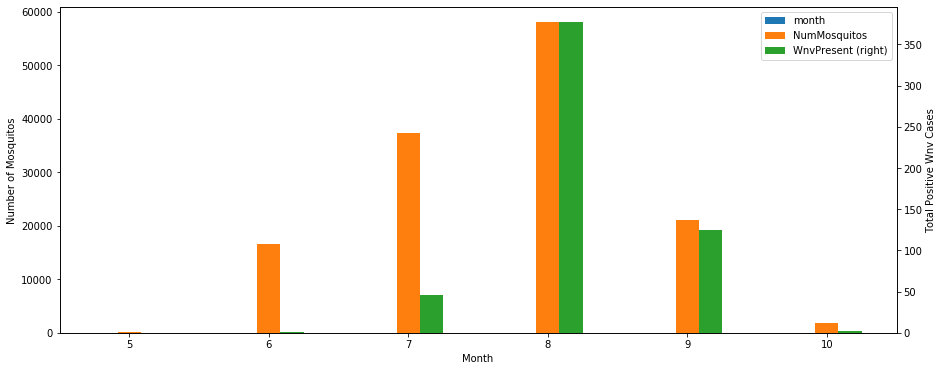

In [55]:
display(year_wnv.sort_values(by='month'))
ax = year_wnv.sort_values(by='month').plot(kind='bar',secondary_y='WnvPresent',rot= 0,figsize=(15,6))
month_labels = year_wnv.sort_values(by='month').month.values
ax.xaxis.set_ticklabels(month_labels)
ax.set_xlabel("Month")
ax.set_ylabel("Number of Mosquitos")
ax.right_ax.set_ylabel("Total Positive Wnv Cases")
plt.show()

It seems that the presence of the West Nile Virus increases sharply in August. We will obtain the coefficients after creating our classifier to determine if seasonality is an important factor in the outbreaks of West Nile virus.  

---
# Export CSVs <a id=csv></a>

In [114]:
train_weather.to_csv('train_weather.csv',index=False)
test_weather.to_csv('test_weather.csv',index=False)